<a href="https://colab.research.google.com/github/AS-Rakshavihasini/Naan-Mudhalvan/blob/main/NM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/rehanfazalkhan/Brain-Tumor-Detection-using-Pytorch-CNN.git

fatal: destination path 'Brain-Tumor-Detection-using-Pytorch-CNN' already exists and is not an empty directory.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from sklearn.utils import shuffle
from PIL import Image
from glob import glob

In [5]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")

else:
  device = torch.device("cpu")



In [6]:
class BrainMRIDataset(Dataset):

  def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder =False):

    self.dataDirectory = data_dir
    self.no_class = glob(data_dir+'/no/*')
    self.yes_class = glob(data_dir+'/yes/*')

    self.height = height
    self.width = width
    self.reshape = reshape
    self.autoencoder = autoencoder

    labels = [0 for i in range(len(self.no_class))]
    labels += [1 for i in range(len(self.yes_class))]

    image_links = self.no_class + self.yes_class

    self.dataframe = pd.DataFrame({"image":image_links, "labels":labels})
    self.dataframe.reset_index(inplace = True ,drop=True)

  def __len__(self):
    return len(self.no_class)+len(self.yes_class)

  def __getitem__(self,idx):

    image_list = self.dataframe["image"][idx]
    label_list = self.dataframe["labels"][idx]

    if type(image_list) == str:
      image_list = [image_list]

    if not isinstance(label_list,np.int64):
      label_list = label_list.values

    image_array = []

    for image in image_list:
      image = Image.open(image).convert("L")

      if self.reshape:
        image = image.resize((self.height,self.width))

      array = np.asarray(image)

      array = array.reshape(1,self.height,self.width)

      image_array.append(array)



    return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]



  def __repr__(self):
    return str(self.dataframe.head(10))

In [7]:
dataset = BrainMRIDataset("/content/drive/MyDrive/Brain_Tumor/brain_tumor_dataset")


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset = BrainMRIDataset("/content/drive/MyDrive/Brain_Tumor/brain_tumor_dataset")


In [10]:
print(dataset)

                                               image  labels
0  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
1  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
2  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
3  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
4  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
5  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
6  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
7  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
8  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0
9  /content/drive/MyDrive/Brain_Tumor/brain_tumor...       0


In [11]:
class BrainTumorModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1,256,kernel_size=3), #126*126*256
        nn.MaxPool2d(2,2), # 63*63*256
        nn.Conv2d(256,32,kernel_size=2) #63-2+1 = 62*62*32
    )
    # n-f+2p/s +1
    self.linear1 = nn.Linear(62,128)
    self.linear2 = nn.Linear(128,64)
    self.flat = nn.Flatten(1)
    self.linear3 = nn.Linear(126976,2)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    x = self.flat(x)
    x = self.linear3(x)
    return x

In [12]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=2, bias=True)
)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [16]:
epochs =10
batch_size = 32
loss_list = []
for epoch in range(epochs):
  total_loss = 0.0
  for n in range(len(dataset)//batch_size):
    data , target = dataset[n*batch_size : (n+1)*batch_size]
    ypred = model.forward(data.float())
    loss = loss_fn(ypred,target)
    total_loss+=loss
    optimizer.zero_grad() #clear the gradients
    loss.backward() # calculate the gradeint
    optimizer.step() # Wn = Wo - lr* gradeint
  loss_list.append(total_loss/batch_size)
  print("Epochs {}  Training Loss {:.2f}".format(epoch+1,total_loss/n))


Epochs 1  Training Loss 1.09
Epochs 2  Training Loss 0.71
Epochs 3  Training Loss 0.98
Epochs 4  Training Loss 0.86
Epochs 5  Training Loss 0.82
Epochs 6  Training Loss 0.89
Epochs 7  Training Loss 0.83
Epochs 8  Training Loss 0.84
Epochs 9  Training Loss 0.85
Epochs 10  Training Loss 0.83


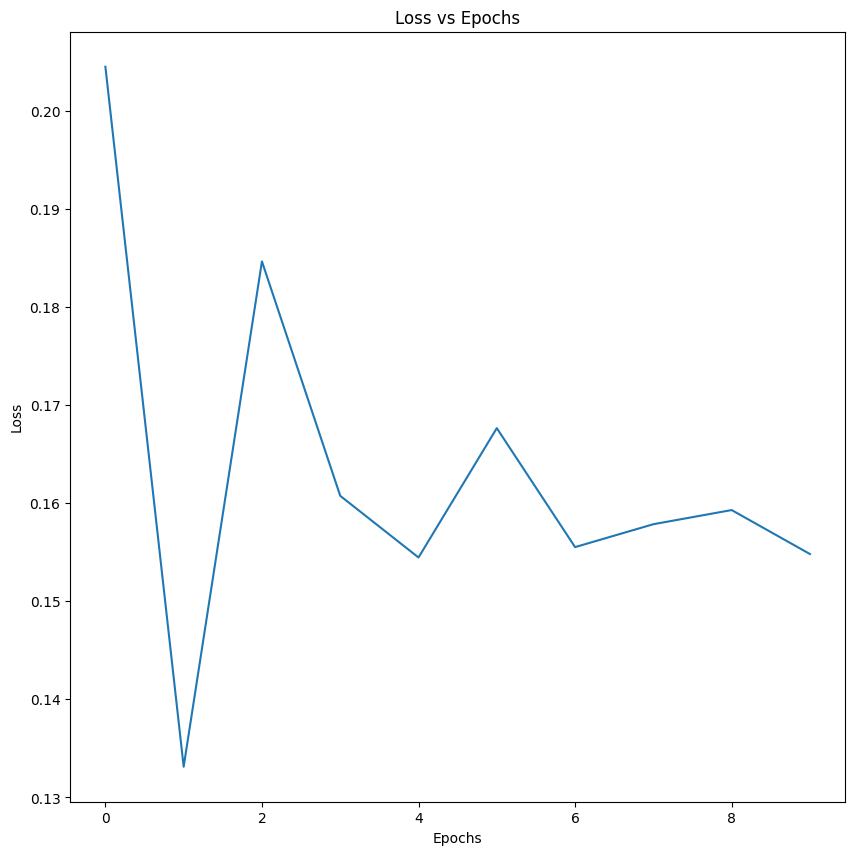

In [25]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)), [loss.detach().item() for loss in loss_list])
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()








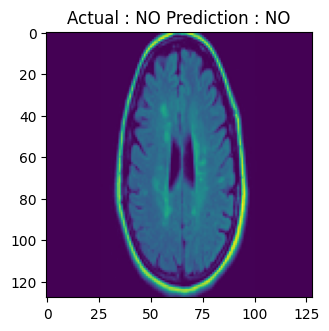

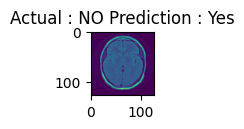

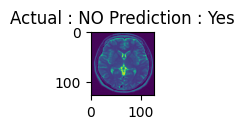

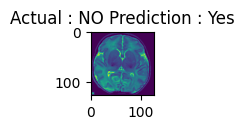

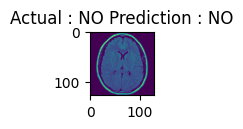

In [26]:
mapping = {0:"NO",1:"Yes"}
fig = plt.figure(figsize=(20,20))
for i in range(5):
  data,target = dataset[i]
  pred = model.forward(data.float())
  pred = torch.argmax(pred,dim=1)
  plt.subplot(5,5,i+1)
  plt.imshow(data[0][0].cpu())
  plt.title(f"Actual : {mapping[target.cpu().detach().item()]} Prediction : {mapping[pred.cpu().detach().item()]}")
  plt.show()